Importamos librerias

In [15]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot

Importamos datos

In [2]:
# Levantamos los datos procesados
datos_meli = pd.read_excel('data_ready_to_model_api_simple.xlsx')
datos_meli['type'] = 'meli'

datos_kavak = pd.read_excel('base_kavak.xlsx')
datos_kavak['type'] = 'kavak' 

In [3]:
# Edito el motor a número
datos_kavak['Motor'] = datos_kavak['Motor'].astype(str)

In [4]:
# Uno los DF
frames = [datos_meli, datos_kavak]
datos = pd.concat(frames)

In [6]:
# Los paso por One Hot Encoder
datos = one_hot_encoder(datos,100)

C:\Users\LUCIA~1.LOP\AppData\Local\Temp/ipykernel_14524/187505526.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  cat_df[str(variable)+'_'+str(label)] = np.where(cat_df[variable]==label,1,0)


Funcion de One Hot Encoder

In [7]:
# Separo los datos de Meli
datos_meli = datos[(datos['type_meli'] == 1)] 
datos_meli = datos_meli.drop('type_kavak',axis=1)
datos_meli = datos_meli.drop('type_meli',axis=1)

In [5]:
# Archivo utilizado para crear la función de One Hot Encoding
############################################################# 

# Función auxiliar: Toma un df de variables categoricas y selección el top_x de categorias
def one_hot_top_x(cat_df, variable,top_x_labels):
    for label in top_x_labels:
        cat_df[str(variable)+'_'+str(label)] = np.where(cat_df[variable]==label,1,0)

# Función One Hot Encoder: Toma un DF y le hace una transformación de One Hot Encoder para con las categorias más repetidas 
def one_hot_encoder(df,top_x):
    # Separo variables categoricas de númericas
    num_cols = df.select_dtypes(include=['float64', 'int']).columns.to_list()
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.to_list()
    
    # Armo un DF solo con variables categoricas
    cat_df = df.drop(num_cols,axis=1)
    # Armo un DF solo con variables categoricas
    num_df = df.drop(cat_cols,axis=1)
   
    # Itero entre las variables categoricas y me quedo con el top 10 variables
    for variable in cat_cols:
        top_10 = [x for x in cat_df[variable].value_counts().sort_values(ascending=False).head(top_x).index]
        one_hot_top_x(cat_df,variable,top_10)
    
    cat_df = cat_df.drop(cat_cols,axis=1)
    df = pd.concat([cat_df,num_df], axis =1)
    
    return df

Separamos en Train & Test

In [8]:
#separate the other attributes from the predicting attribute
x = datos_meli.drop('price',axis=1)

#separte the predicting attribute into Y for model training 
y = datos_meli['price']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

In [60]:
#print(x.columns)
#x.to_excel('check.xlsx', index=False)
# 5684 rows × 424 columns

Index(['currency_id_ARS', 'condition_used', 'Marca_Honda', 'Marca_Ford',
       'Marca_Toyota', 'Marca_Citroën', 'Marca_Renault', 'Marca_Chery',
       'Marca_Nissan', 'Marca_Chevrolet',
       ...
       'Motor_diesel', 'Motor_1997cm3', 'Motor_2.0 140cv',
       'Transmisión_Manual', 'Transmisión_Automática',
       'Transmisión_Automática secuencial', 'id', 'Puertas', 'Kilómetros',
       'Año'],
      dtype='object', length=424)


Entrenamos el modelo

In [9]:
# Modelo Simple
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,y_train)

[18:29:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=10, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

Miramos resultados

In [10]:
y_pred = xg_reg.predict(X_test)

print('MAE: Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred)/1000000,2))
# MAE: Mean Absolute Error: 1.08
# MAE: Mean Absolute Error: 0.87
# MAE: Mean Absolute Error: 1.23 (con nueva base de API)

print('MSE: Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred)/1000000,2))
# MSE: Mean Squared Error: 7,272,534.09
# MSE: Mean Squared Error: 1,430,040.43
# MSE: Mean Squared Error: 2655269.87
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred))/1000000,2))
# Root Mean Squared Error: 2.7
# Root Mean Squared Error: 1.2
# Root Mean Squared Error: 1.63

MAE: Mean Absolute Error: 1.22
MSE: Mean Squared Error: 2678243.96
Root Mean Squared Error: 1.64


Text(0.5, 1.0, 'Feature Importance')

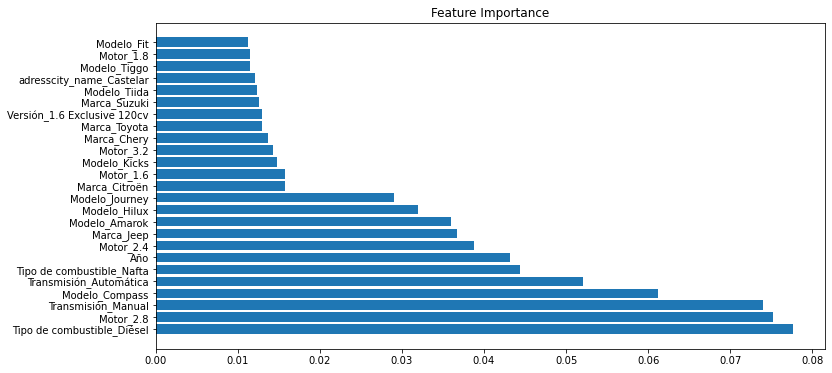

In [173]:
# Miro la importancia de las variables

feature_importance = xg_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(0,25), feature_importance[sorted_idx][::-1][:25], align='center')
plt.yticks(range(0,25), np.array(X_test.columns)[sorted_idx][::-1][:25])
plt.title('Feature Importance')


Text(0.5, 1.0, 'Feature Importance')

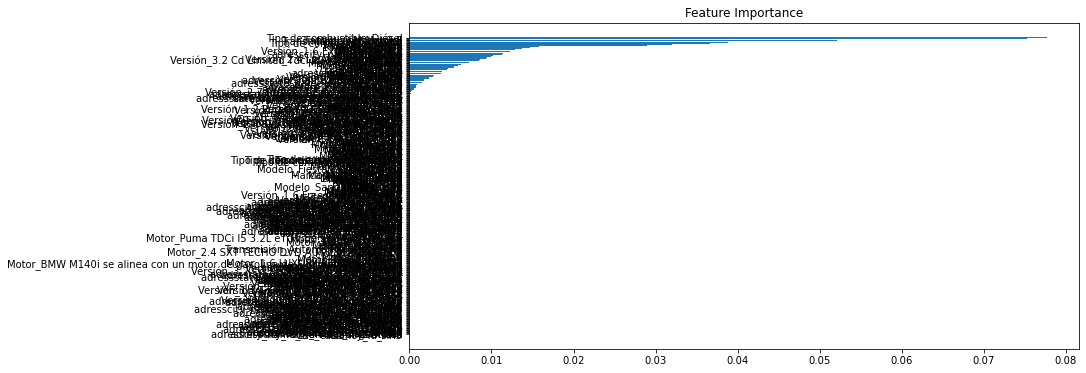

In [171]:
# Miro la importancia de las variables

feature_importance = xg_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

Optimizamos parametros

In [183]:
########################################## Optimizando los hiperparametros
########################################## GridSearchCV

params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 300, 500],
           'colsample_bytree': [0.3, 0.7]}

xgbr = xgb.XGBRegressor(seed = 20)
clf_GS = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   # scoring='neg_mean_squared_error',
                   scoring = 'neg_mean_absolute_error',
                   verbose=1)

clf_GS.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)

y_pred_test = clf_GridS.best_estimator_(X_test)
y_pred_train = clf_GridS.best_estimator_(X_train)

print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))/1000000,2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))/1000000,2))


# Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}
print("Lowest RMSE: ", round(((-clf_GridS.best_score_)**(1/2.0)/1000000),2))
# Lowest RMSE:  0.44
print("Lowest MSE: ", round((-clf_GridS.best_score_/1000000),2))
# Lowest MSE:  197.270.95

Fitting 5 folds for each of 54 candidates, totalling 270 fits


NameError: name 'clf' is not defined

In [ ]:
best_estimator_.feature_importances_

In [174]:
########################################## RandomSearch

params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

xgbr = xgb.XGBRegressor(seed = 20)
clf_RandomS = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=10,
                         verbose=1)
clf_RandomS.fit(X_train, y_train)

print("Best parameters:", clf_RandomS.best_params_)
# print("Best parameters:", clf_RandomS.best_params_)
# Best parameters: {'subsample': 0.8999999999999999, 'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.2, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.7}
print("Lowest RMSE: ", round(((-clf_RandomS.best_score_)**(1/2.0)/1000000),2))
# Lowest RMSE:  0.46
# Lowest RMSE:  0.69 (con api data)
print("Lowest MSE: ", round((-clf_RandomS.best_score_/1000000),2))
# Lowest MSE:  213.030.49
# Lowest MSE: 456.262.19 (con api Data)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'subsample': 0.7999999999999999, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.6}
Lowest RMSE:  1.81
Lowest MSE:  3290047.19


In [182]:
# Miro la importancia de las variables

feature_importance = best_score_.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(0,25), feature_importance[sorted_idx][::-1][:25], align='center')
plt.yticks(range(0,25), np.array(X_train.columns)[sorted_idx][::-1][:25])
plt.title('Feature Importance')

NameError: name 'best_score_' is not defined

In [ ]:
print('MAE: Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred)/1000000,2))
# MAE: Mean Absolute Error: 1.08
# MAE: Mean Absolute Error: 0.87
# MAE: Mean Absolute Error: 1.23 (con nueva base de API)
# MAE: Mean Absolute Error: 0.29
print('MSE: Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred)/1000000,2))
# MSE: Mean Squared Error: 7,272,534.09
# MSE: Mean Squared Error: 1,430,040.43
# MSE: Mean Squared Error: 2655269.87
# MSE: Mean Squared Error: 210.388.38
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred))/1000000,2))
# Root Mean Squared Error: 2.7
# Root Mean Squared Error: 1.2
# Root Mean Squared Error: 1.63
# Root Mean Squared Error: 0.46

Analizo los datos de Kavak

In [226]:
####################################################
#### Prueba de datos de Kavak

# Separo en Y y X
datos_kavak = datos[(datos['type_kavak'] == 1)] 
datos_kavak = datos_kavak.drop('type_kavak',axis=1)
datos_kavak = datos_kavak.drop('type_meli',axis=1)

#separate the other attributes from the predicting attribute
x_kavak = datos_kavak.drop('price',axis=1)

#separte the predicting attribute into Y for model training 
y_kavak = datos_kavak['price']


0       2830994
1       3446693
2       3436740
3       3697161
4       6076641
         ...   
2233    2578698
2234    3195849
2235    5221806
2236    6035456
2237    2197163
Name: price, Length: 2238, dtype: int64

In [188]:
# Predigo las x_kavak
#y_pred_kavak_ln = model.predict(x_kavak)

#y_pred = xg_reg.predict(X_test)

#  Saco exponencial de los valores de Y
#y_pred_kavak = np.exp(y_pred_kavak_ln)/1000

#print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_kavak, y_pred_kavak)/1000000,2))
# Mean Absolute Error: 126.93

In [185]:
y_pred = clf_RandomS.predict(x_kavak)
# y_pred_test = clf_RandomS.best_estimator_(X_kavak)

In [187]:
print('MAE: Mean Absolute Error:', round(metrics.mean_absolute_error(y_kavak, y_pred)/1000000,2))
# MAE: Mean Absolute Error: 1.08
# MAE: Mean Absolute Error: 0.87
# MAE: Mean Absolute Error: 1.23 (con nueva base de API)
# MAE: Mean Absolute Error: 0.29
print('MSE: Mean Squared Error:', round(metrics.mean_squared_error(y_kavak, y_pred)/1000000,2))
# MSE: Mean Squared Error: 7,272,534.09
# MSE: Mean Squared Error: 1,430,040.43
# MSE: Mean Squared Error: 2655269.87
# MSE: Mean Squared Error: 210.388.38
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_kavak, y_pred))/1000000,2))
# Root Mean Squared Error: 2.7
# Root Mean Squared Error: 1.2
# Root Mean Squared Error: 1.63
# Root Mean Squared Error: 0.46

MAE: Mean Absolute Error: 0.48
MSE: Mean Squared Error: 391221.8
Root Mean Squared Error: 0.63


In [235]:
df_kavak = pd.DataFrame(y_kavak)
df_kavak

df_pred = pd.DataFrame(y_pred, columns = ['y_pred'])
df_pred

frames = [df_kavak, df_pred, x_kavak]
data_analisis = pd.concat(frames, axis = 1)

data_analisis



,price,y_pred,currency_id_ARS,condition_used,Marca_Ford,Marca_Honda,Marca_Toyota,Marca_Renault,Marca_Volkswagen,Marca_Chevrolet,...,Motor_3.8,Motor_1.6 16V,Motor_1.1,Transmisión_Manual,Transmisión_Automática,Transmisión_Automática secuencial,id,Puertas,Kilómetros,Año
0,2830994,3136072.50,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,174506,4,1012,2022
1,3446693,3734184.00,1,1,0,0,0,0,0,1,...,0,0,0,1,0,0,170579,5,1020,2022
2,3436740,3066126.25,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,179998,4,1023,2022
3,3697161,3830035.50,1,1,1,0,0,0,0,0,...,0,0,0,0,1,0,164802,5,1042,2020
4,6076641,5335502.50,1,1,0,0,0,0,1,0,...,0,0,0,0,1,0,139688,5,1052,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233,2578698,2249939.75,1,1,1,0,0,0,0,0,...,0,0,0,1,0,0,183498,5,101000,2014
2234,3195849,3352842.75,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,178515,4,101015,2018
2235,5221806,4113434.75,1,1,1,0,0,0,0,0,...,0,0,0,1,0,0,166491,4,101050,2017
2236,6035456,5683670.00,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,159926,4,102000,2017


Exporto los Datos a Medir

In [240]:
data_analisis.to_excel('data_analisis_kavak.xlsx', index=False)